In [1]:
import numpy as np
import pandas as pd
import transformers
import torch

from tqdm import tqdm, trange
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


2024-05-24 17:42:40.413583: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 17:42:40.460596: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 17:42:41.319423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv('/home/vikrant/Desktop/Thesis/Thesis_Projects/URL_detection/Githubdataset/dataset_full.csv')
data.head(50)

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
5,1,0,0,2,0,0,0,0,0,0,...,1,3,3,3591,1,0,0,0,0,1
6,2,0,0,0,0,0,0,0,0,0,...,1,2,2,291,0,0,0,0,0,0
7,2,0,0,3,0,0,0,0,0,0,...,1,2,1,3134,1,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3596,1,1,0,0,0,0
9,1,0,0,2,0,0,0,0,0,0,...,1,2,1,14397,1,0,0,0,0,1


In [3]:
# Assuming the last column is the label
X = data.iloc[:, :-1]
y = data.iloc[:, -1]


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Split into training and testing sets (optional, since we are only extracting features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)

# Fit PCA on scaled training data and find the optimal number of components
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Find the number of components that explain 100% of the variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 1.0) + 1

# Transform the entire dataset using the optimal number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA components to a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f'pca_{i}' for i in range(n_components)])

# Concatenate PCA components into a single string without decimal places
X_pca_df['feature_string'] = X_pca_df.apply(lambda row: '/'.join(map(str, row.values)), axis=1)

# Prepare the final DataFrame with original labels
final_df_pca = pd.DataFrame({'features': X_pca_df['feature_string'], 'label': y})

# Show the features selected by PCA
print(f'Number of PCA components selected: {n_components}')
print('PCA components captured:', X_pca_df.columns[:-1].tolist())

# Print the final DataFrame
print(final_df_pca.head())

Number of PCA components selected: 91
PCA components captured: ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49', 'pca_50', 'pca_51', 'pca_52', 'pca_53', 'pca_54', 'pca_55', 'pca_56', 'pca_57', 'pca_58', 'pca_59', 'pca_60', 'pca_61', 'pca_62', 'pca_63', 'pca_64', 'pca_65', 'pca_66', 'pca_67', 'pca_68', 'pca_69', 'pca_70', 'pca_71', 'pca_72', 'pca_73', 'pca_74', 'pca_75', 'pca_76', 'pca_77', 'pca_78', 'pca_79', 'pca_80', 'pca_81', 'pca_82', 'pca_83', 'pca_84', 'pca_85', 'pca_86', 'pca_87', 'pca_88', 'pca_89', 'pca_90']
                                    

In [5]:
new_data = final_df_pca

In [6]:
new_data

,features,label
0,4.566955384403107/-3.482237148881002/-0.388958...,1
1,12.15328735585429/10.242753498029453/-0.135974...,1
2,4.066018638366945/-3.5109564053561124/-0.66570...,0
3,6.229161288292943/-3.5324338391657464/0.652238...,1
4,-5.18239156050509/1.1022584798369721/0.1092068...,0
...,...,...
88642,-4.870443714825954/1.606208655936256/0.6309385...,0
88643,-5.107544984452614/1.0822400882724643/0.675642...,0
88644,5.539981148245862/-3.708580749997472/-0.010545...,1
88645,4.1108737344368285/-3.4789571749134938/-0.3737...,1


In [7]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f'There are {torch.cuda.device_count()} GPU(s) available.')
print('Device name:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
Device name: NVIDIA RTX A5000


In [8]:
# Count unique occurrences of 0s and 1s in the dataset
label_counts = new_data['label'].value_counts()
print("Counts of unique labels:")
print(label_counts)

Counts of unique labels:
label
0    58000
1    30647
Name: count, dtype: int64


In [9]:
sentences = new_data['features'].values
labels = new_data['label'].values

In [10]:
sentences[0:5]

array(['4.566955384403107/-3.482237148881002/-0.3889585459176452/-0.2713392705669294/1.1712433268262499/0.618182442053795/-0.48379836949628363/-1.1254051847999496/-0.22913822738417033/0.41538351953520974/0.1400402137330163/-0.19503321950114888/0.12278544439368459/-0.16294830212805478/-0.634990787449946/0.19815100446761275/-0.09963111763609389/0.023945992970974096/-0.22156013265690558/0.15207878917880654/0.22467094523525646/0.15967208755276804/-0.30637422146367843/-0.10041449404301954/-0.2946522816952481/-0.3363772751397837/0.08602802816872891/0.462390365066164/-0.13195958685254824/-1.2165375996216143/-0.1812586699188561/0.7807952024837096/-0.4345914665134079/0.6539728065573315/0.1447176435976098/0.08088114483722378/0.12259322447015074/0.15940789737306535/-0.7011631062196599/0.057032039565253316/0.003050021713861149/-0.6862081600946827/0.0024344388968282555/-0.019258933313203698/0.1201392984714456/0.3323395618894127/0.23297833810708685/-0.4859912591079544/0.23756526051393925/0.157896044

In [11]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

/home/vikrant/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# Tokenize the sentences
input_ids = []
attention_masks = []

max_length = 128  # Adjusted sequence length for better performance

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens=True,
                        max_length=max_length,
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
input_ids[0:3]
attention_masks[0:3]

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [15]:
# Split the data into 80% training and 20% test set
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels,
                                                                        random_state=2018, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_masks, attention_masks,
                                                 random_state=2018, test_size=0.2)

# Further split the training data into 75% training and 25% validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels,
                                                                                    random_state=2018, test_size=0.25)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_masks,
                                                       random_state=2018, test_size=0.25)

# Create the DataLoader for training, validation, and test sets
batch_size_train = 32
batch_size_val = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size_train)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size_val)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size_val)


In [16]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

model.to(device)

/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [17]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 10
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/home/vikrant/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Early stopping criteria
patience = 2
early_stopping_counter = 0
best_validation_loss = float('inf')

In [19]:
# Training loop
loss_values, validation_loss_values = [], []

for epoch_i in range(0, epochs):
    print(f'Epoch {epoch_i + 1}/{epochs}')
    print('Training...')

    model.train()
    total_loss = 0

    # Shuffle the training data at the beginning of each epoch
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size_train)

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print(f'Average training loss: {avg_train_loss}')

    print('Running Validation...')
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_loss = outputs.loss.item()  # Adjusted this line to correctly access loss
        eval_loss += tmp_eval_loss

        preds_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        eval_accuracy += np.sum(preds_flat == labels_flat) / len(labels_flat)

        nb_eval_steps += 1

    avg_val_accuracy = eval_accuracy / nb_eval_steps
    avg_val_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(avg_val_loss)

    print(f'Validation Accuracy: {avg_val_accuracy}')
    print(f'Validation Loss: {avg_val_loss}')

    # Early stopping
    if avg_val_loss < best_validation_loss:
        best_validation_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print('Early stopping triggered.')
        break

print(f'Training complete!')

Epoch 1/10
Training...
Average training loss: 0.23808720870972827
Running Validation...
Validation Accuracy: 0.9154676258992805
Validation Loss: 0.21885278368060537
Epoch 2/10
Training...
Average training loss: 0.2029157298797953
Running Validation...
Validation Accuracy: 0.9205822841726619
Validation Loss: 0.19454940941801174
Epoch 3/10
Training...
Average training loss: 0.189018691568347
Running Validation...
Validation Accuracy: 0.9275517086330936
Validation Loss: 0.18377481742674928
Epoch 4/10
Training...
Average training loss: 0.1762532249358508
Running Validation...
Validation Accuracy: 0.9312050359712231
Validation Loss: 0.18193065865541533
Epoch 5/10
Training...
Average training loss: 0.16551331658071994
Running Validation...
Validation Accuracy: 0.930193345323741
Validation Loss: 0.18173515487113873
Epoch 6/10
Training...
Average training loss: 0.15468227685503638
Running Validation...
Validation Accuracy: 0.9319919064748201
Validation Loss: 0.18461201157715681
Epoch 7/10
Trai

              precision    recall  f1-score   support

           0     0.9553    0.9381    0.9466     11691
           1     0.8842    0.9151    0.8993      6039

    accuracy                         0.9302     17730
   macro avg     0.9197    0.9266    0.9230     17730
weighted avg     0.9311    0.9302    0.9305     17730



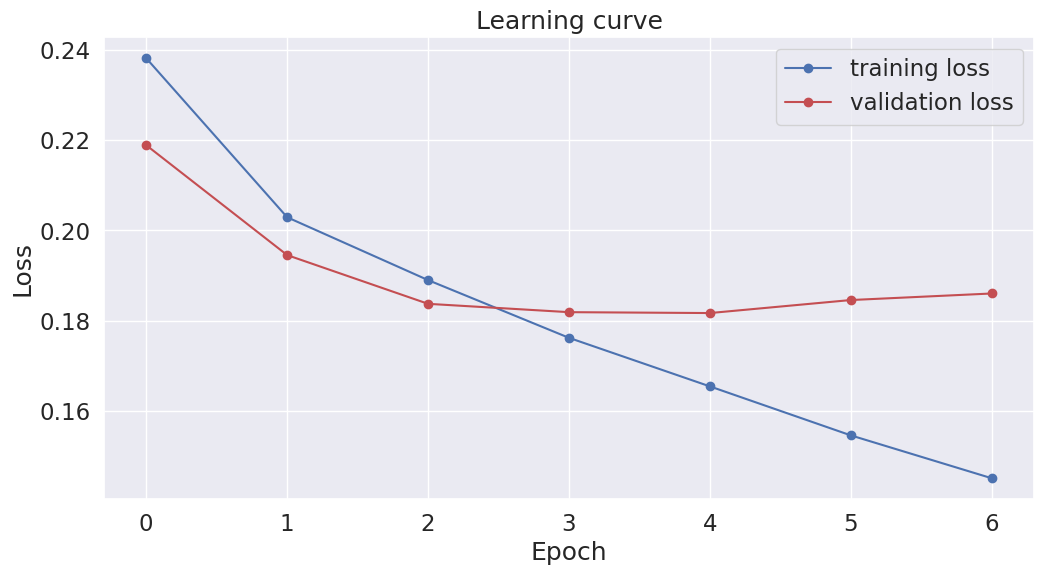

In [20]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate on the test set
model.eval()
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Print classification report
print(classification_report(true_labels, predictions, digits=4))

# Plot the learning curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()